In [1]:
using Plots, LinearAlgebra, Statistics, SparseArrays, Arpack, FFTW

# Stage by Stage

**Input Data**

Two layers with thickness d, size L.
Assume Gaussian function delta layer
z = 0 at the top of layer 1, x = 0 on the left of each cell

In [ ]:
L = 1 # width of cell [arb]
λ₀ = 1.2 # incoming light wavelength [units of L]
ω₀ = 2*pi/λ₀

ϵ₁ = 1 # air in the first layer
d₁ = 2 # thickness of first layer [units of L]
ϵ₂ = 1 # air in the second layer
d₂ = 2 # thickness of second layer [units of L]

delta(n) = n == 0
f0(x, z) = @. 1+ 5*delta(x-x) * delta(z-d₁) # constant surface dielectric
f1(x, z) = @. 1+ exp(-(x-L/2)^2/(2*L^2/16)) * delta(z-d₁) # gaussian function in x

nvec = 0:99 # 100 modes

In [ ]:
kₓ = 2*pi*fftfreq(length(nvec), length(nvec)/L) 

In [ ]:
#### initial wave
xvec = range(0, L, length=length(nvec)+1)[1:length(nvec),]

u_p = [mod(n, 3) == 0 ? 1 : 0 for n in nvec] # all even modes set to 1, p is the positive side
u_n = [mod(n, 4) == 0 ? 1 : 0 for n in nvec] # all multiples of 3 set to 1, n is the negative side

E_in_p = ifft(u_p)
E_in_n = ifft(u_n)

plot(xvec, abs.(E_in_p))
plot!(xvec, abs.(E_in_n))



In [ ]:
#### propagate through first layer. (right before boundary)
β₁ = @. sqrt(Complex(ω₀^2*ϵ₁ - kₓ^2)) # propagation constant in first layer
β₂ = @. sqrt(Complex(ω₀^2*ϵ₂ - kₓ^2)) # propagation constant in second layer

u_p = u_p .* exp.(1im*β₁*d₁)
u_n = u_n .* exp.(1im*β₂*d₂)

E_in_p = ifft(u_p)
E_in_n = ifft(u_n)

plot(xvec, abs.(E_in_p))
plot!(xvec, abs.(E_in_n))

In [ ]:
#### Scattering matrix (one mode)
k = ω₀
βₙ = @. sqrt(Complex(ω₀^2*ϵ₁ - kₓ^2))


M = Matrix(Diagonal(repeat([1], length(nvec))*1im))
N = Matrix(Diagonal(repeat([6], length(nvec))*1im))

A = [-Diagonal(βₙ)-k*M -Diagonal(βₙ)-k*M; -Diagonal(βₙ)-k*N Diagonal(βₙ)+k*N]
B = [-Diagonal(βₙ)+k*M -Diagonal(βₙ)+k*M; Diagonal(βₙ)+k*N -Diagonal(βₙ)-k*N]

S = A\B


In [ ]:
ip = [findall(isreal, βₙ); findall(isreal, βₙ).+length(βₙ)]
Sp = S[ip,ip]

In [ ]:
norm(Sp'Sp-I)/norm(Sp'Sp)

In [ ]:
norm(S'S-I)/norm(S'S)

In [ ]:
#### Scattering matrix (all modes)
k = w0
# M = Matrix(Diagonal(rand(length(nvec))*1im))
# N = Matrix(Diagonal(rand(length(nvec))*1im))
M = Matrix(Diagonal(repeat([1], length(nvec))*1im))
N = Matrix(Diagonal(repeat([6], length(nvec))*1im))
A = [-Diagonal(β₁)-k*ifft(fft(M, 2), 1)    -Diagonal(β₁)-k*ifft(fft(M, 2), 1);
    -Diagonal(β₁)-k*ifft(fft(N, 2), 1)     Diagonal(β₁)+k*ifft(fft(N, 2), 1)]
B = [Diagonal(β₁)+k*ifft(fft(M, 2), 1)    Diagonal(β₁)+k*ifft(fft(M, 2), 1);
    Diagonal(β₁)+k*ifft(fft(N, 2), 1)      -Diagonal(β₁)-k*ifft(fft(N, 2), 1)]

#     A = [-2*Diagonal(β)-k*ifft(fft(M+N, 2), 1)    -k*ifft(fft(M-N, 2), 1);
#         -k*ifft(fft(N-M, 2), 1)                   2*Diagonal(β)+k*ifft(fft(N+M, 2), 1)]
#     B = [-2*Diagonal(β)+k*ifft(fft(M+N, 2), 1)    k*ifft(fft(M-N, 2), 1);
#         k*ifft(fft(N-M, 2), 1)                  2*Diagonal(β)-k*ifft(fft(N+M, 2), 1)]

S = A\B


In [ ]:
norm(S'S-I)/norm(S'S)

# Functions

In [ ]:
#### - function: pass in array of M and N, L, lambda -> outputs S matrix and array of betas
function get_all_modes(M, N, L, λ)
    """ assumes epsilon and mu are 1 
    L is the width of the cell
    λ is in units of L
    M, N are surface permitvities, expressed as a diagonal matrix"""

    ω₀ = 2*pi/λ
    k = ω₀
    nvec = 0:length(M)^0.5-1 # 100 modes
    kₓ = 2*pi*fftfreq(length(nvec), length(nvec)/L) 
    β = @. sqrt(Complex(ω₀^2 - kₓ^2))
    
    A = [Diagonal(β)+k*ifft(fft(M, 2), 1)    Diagonal(β)+k*ifft(fft(M, 2), 1);
        Diagonal(β)+k*ifft(fft(N, 2), 1)     -Diagonal(β)-k*ifft(fft(N, 2), 1)]
    B = [Diagonal(β)-k*ifft(fft(M, 2), 1)    Diagonal(β)-k*ifft(fft(M, 2), 1);
        Diagonal(β)-k*ifft(fft(N, 2), 1)      -Diagonal(β)+k*ifft(fft(N, 2), 1)]
    
    S = A\B
    return S, β
end

In [ ]:
#### - function: pass in S and beta, -> outputs propagating modes only
function get_prop_modes(S, β)
    i_real = findall(isreal, β)
    ip = [i_real; i_real.+length(β)]
    Sp = S[ip,ip]
    βp = β[i_real]
    print(norm(Sp'Sp-I)/norm(Sp'Sp))
    
    return Sp, βp
end

In [ ]:
#### - function: compute transmission for kx = 0 (normal incident transitivity)
function get_transmissivity_normalincident(M, N, L, λ, u_in₁, u_in₂)
    """ assumes epsilon and mu are 1 
    L is the width of the cell
    λ is in units of L
    M, N are surface permitvities, expressed as a diagonal matrix"""
    
    S, β = get_all_modes(M, N, L, λ)
    u_in = [u_in₁; u_in₂]
    u_out = S*u_in
    u_out₁ = u_out[1:length(u_in₁)]
    u_out₂ = u_out[length(u_in₁)+1:length(u_out)]
    
    T = (abs(u_out₂[1])/abs(u_in₁[1]))^2
    phase = angle(u_out₂[1]) - angle(u_in₁[1])
    
    return T, phase
end

In [ ]:
nvec = 0:99
M = Matrix(Diagonal(repeat([2], length(nvec))*1im))
N = Matrix(Diagonal(repeat([0.5], length(nvec))*1im))

# M = Matrix(Diagonal(rand(length(nvec))*10im))
# N = Matrix(Diagonal(rand(length(nvec))*1im))

# M = Matrix(Diagonal([(n > 45 && n < 75) ? 1 : 0 for n in nvec])*10im)
# N = Matrix(Diagonal([(n > 45 && n < 75) ? 1 : 0 for n in nvec])*10im)

u_p = [n == 0 ? 1 : 0 for n in nvec]
u_n = [n == 0 ? 0 : 0 for n in nvec]

# plot(abs.(u_p), label="region 1")
# display(plot!(abs.(u_n), label="region 2"))

λ_vec = 0.25:1e-2:2
N_vec = 0.5:0.1:2
T = zeros(0)
for λi in λ_vec
#     N = Matrix(Diagonal(repeat([Ni], length(nvec))*1im))
    Ti, phasei = get_transmissivity_normalincident(M, N, 1, λi, u_p, u_n)
    append!(T, Ti)
end

In [ ]:
plot(λ_vec, T, ylim=(-0.1, 1.1))

In [ ]:
nvec = 0:2
M = Matrix(Diagonal(repeat([1], length(nvec))*0im))
N = 4*M

u_p = [n == 0 ? 1 : 0 for n in nvec]
u_n = [n == 0 ? 0 : 0 for n in nvec]

S, β = get_all_modes(M, N, 1, 0.5)
u_in = [u_p; u_n]
u_out = S*u_in
display(β)
# display(S)
display(u_in)
display(u_out)

# Debugging

In [ ]:
#### trying to debug (5/6/21)
nvec = 0:3
λ = 0.25
L = 1

Y_vec = 0:0.01:10
T = zeros(0)
for Yi in Y_vec
    Y = Matrix(Diagonal(repeat([1], length(nvec))*Yi*(1im)))
    # Y = Matrix(Diagonal([0; 1; 2; 3; 2; 1; 0])*1im)

    u_p = [n == 0 ? 1 : 0 for n in nvec]
    u_n = [n == 0 ? 0 : 0 for n in nvec]

    ω₀ = 2*pi/λ
    k = ω₀
    nvec = 0:length(Y)^0.5-1 # 100 modes
    kₓ = 2*pi*fftfreq(length(nvec), length(nvec)/L) 
    β = @. sqrt(Complex(ω₀^2 - kₓ^2))
    # display(β)

    A = [Diagonal(β)+0.5*k*ifft(fft(Y, 2), 1)    Diagonal(β)+0.5*k*ifft(fft(Y, 2), 1);
        Diagonal(β)+2*k*ifft(fft(Y, 2), 1)     -Diagonal(β)-2*k*ifft(fft(Y, 2), 1)]
    B = [Diagonal(β)-0.5*k*ifft(fft(Y, 2), 1)    Diagonal(β)-0.5*k*ifft(fft(Y, 2), 1);
        Diagonal(β)-2*k*ifft(fft(Y, 2), 1)      -Diagonal(β)+2*k*ifft(fft(Y, 2), 1)]

    S = A\B
    # display(S)

    u_in = [u_p; u_n]
    u_out = S*u_in

    append!(T, abs(u_out[5]))
#     println(abs(u_out[5])^2 + abs(u_out[1])^2)
end

plot(Y_vec, T)

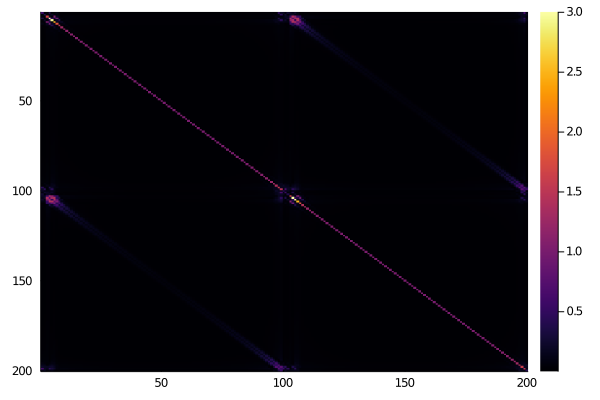

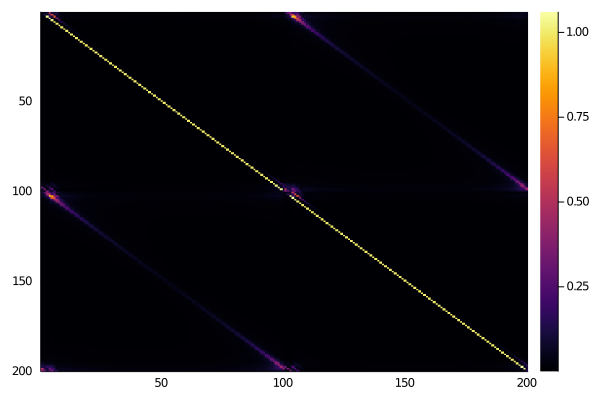

0.5828670172365966

In [168]:
print(norm(S'S-I)/norm(S'S))
display(heatmap(abs.(S'S), yflip=true))
display(heatmap(abs.(S), yflip=true))

In [ ]:
nvec = 0:3
M = Matrix(Diagonal(repeat([0.1], length(nvec))*1im))
N = Matrix(Diagonal(repeat([100], length(nvec))*1im))

u_p = [n == 0 ? 1 : 0 for n in nvec]
u_n = [n == 0 ? 0 : 0 for n in nvec]

# S, β = get_all_modes(M, N, 1, 0.5)
L = 1
λ = 0.75
ω₀ = 2*pi/λ
k = ω₀
nvec = 0:length(M)^0.5-1 # 100 modes
kₓ = 2*pi*fftfreq(length(nvec), length(nvec)/L) 
β = @. sqrt(Complex(ω₀^2 - kₓ^2))
# display(β)

A = [-Diagonal(β)-k*ifft(fft(M, 2), 1)    -Diagonal(β)-k*ifft(fft(M, 2), 1);
    -Diagonal(β)-k*ifft(fft(N, 2), 1)     Diagonal(β)+k*ifft(fft(N, 2), 1)]
B = [-Diagonal(β)+k*ifft(fft(M, 2), 1)    -Diagonal(β)+k*ifft(fft(M, 2), 1);
    -Diagonal(β)+k*ifft(fft(N, 2), 1)     Diagonal(β)-k*ifft(fft(N, 2), 1)]
S = A\B
# display(S)

u_in = [u_p; u_n]
u_out = S*u_in
display(u_in)
display(u_out)
println("reflection: ", abs(u_out[1])^2)
println("transmission: ", abs(u_out[5])^2)
println("energy: ", abs(u_out[1])^2 + abs(u_out[5])^2)

In [ ]:
nvec = 0:3
M = Matrix(Diagonal(repeat([2], length(nvec))*1im))
N = Matrix(Diagonal(repeat([2], length(nvec))*1im))

u_p = [n == 0 ? 1 : 0 for n in nvec]
u_n = [n == 0 ? 0 : 0 for n in nvec]

# S, β = get_all_modes(M, N, 1, 0.5)
L = 1
λ = 0.75
ω₀ = 2*pi/λ
k = ω₀
nvec = 0:length(M)^0.5-1 # 100 modes
kₓ = 2*pi*fftfreq(length(nvec), length(nvec)/L) 
β = @. sqrt(Complex(ω₀^2 - kₓ^2))
# display(β)

T = zeros(0)
Nvec = 1:1:100
for Ni in Nvec
    N = Matrix(Diagonal(repeat([Ni], length(nvec))*1im))
    A = [-Diagonal(β)-k*ifft(fft(M, 2), 1)    -Diagonal(β)-k*ifft(fft(M, 2), 1);
        -Diagonal(β)-k*ifft(fft(N, 2), 1)     Diagonal(β)+k*ifft(fft(N, 2), 1)]
    B = [-Diagonal(β)+k*ifft(fft(M, 2), 1)    -Diagonal(β)+k*ifft(fft(M, 2), 1);
        -Diagonal(β)+k*ifft(fft(N, 2), 1)     Diagonal(β)-k*ifft(fft(N, 2), 1)]
    S = A\B
    # display(S)

    u_in = [u_p; u_n]
    u_out = S*u_in
#     display(u_in)
#     display(u_out)
#     println("reflection: ", abs(u_out[1]))
#     println("transmission: ", abs(u_out[5]))
#     println("energy: ", abs(u_out[1])^2 + abs(u_out[5])^2)
    append!(T, abs(u_out[5]))

end
plot(Nvec, T)

In [ ]:
heatmap(abs.(S'S))

In [ ]:
heatmap(abs.(S))

In [ ]:
#### apply S matrix
u_out = S*[uy_p ; uy_n]
uy_p = u_out[1:Int(length(u_out)/2)]
uy_n = u_out[Int(length(u_out)/2)+1:Int(length(u_out))]


In [ ]:
#### right after boundary
E_outp = ifft(uy_p)
E_outn = ifft(uy_n)

# plot(xvec, abs.(E_outp))
# plot!(xvec, abs.(E_outn))

plot(nvec, abs.(uy_p))
plot!(nvec, abs.(uy_n))


In [ ]:
#### check conservation of energy
abs(dot(conj(E_in_p), E_in_p))
abs(dot(conj(E_in_n), E_in_n))

abs(dot(conj(E_outp), E_outp))
abs(dot(conj(E_outn), E_outn))

In [ ]:
#### propagate through second layer
# u_y_p = @. u_y_p * exp(1im * b1 * d1)
# u_y_n = @. u_y_n * exp(-1im * b2 * d2)

println(u_y_p)
println(u_y_n)

E_outp = ifft(u_y_p)
E_outn = ifft(u_y_n)
plot(xvec, abs.(E_outp))
# plot(xvec, abs.(E_outn))

In [ ]:
#### OLD Not Needed Anymore OLD ####

Nx = 10 # number of discretized points in x

h = L/Nx
rows = vcat([[i, i, i] for i=1:Nx]...)
cols = vcat(vcat([[1,2,3]], [[i-1, i, i+1] for i=2:Nx-1], [Nx.-[2,1,0]])...)
vals = repeat([1,-2,1]./h^2, Nx)
A = sparse(rows, cols, vals, Nx, Nx) + w0^2*e1*I

vals, vecs = eigs(Array(A))

print(vals)
# print(vecs)

In [101]:
#### trying to debug (5/19/21)
nvec = 0:3
ϵ = repeat([1], length(nvec))
μ = repeat([1], length(nvec))

u_p = [n == 0 ? 1 : 0 for n in nvec]
u_n = [n == 0 ? 0 : 0 for n in nvec]

# S, β = get_all_modes(M, N, 1, 0.5)
L = 1
λ = 0.75
ω₀ = 2*pi/λ
k = ω₀
# nvec = 0:length(M)^0.5-1 # 100 modes
kₓ = 2*pi*fftfreq(length(nvec), length(nvec)/L) 
β = @. sqrt(Complex(ω₀^2 - kₓ^2))
# display(β)

M = 1im*(k*Matrix(Diagonal(ϵ)))/2
N = 1im*2/k*Matrix(Diagonal(1 ./μ))

A = [-Diagonal(β)-k*ifft(fft(M, 2), 1)    -Diagonal(β)-k*ifft(fft(M, 2), 1);
    -Diagonal(β)-k*ifft(fft(N, 2), 1)     Diagonal(β)+k*ifft(fft(N, 2), 1)]
B = [-Diagonal(β)+k*ifft(fft(M, 2), 1)    -Diagonal(β)+k*ifft(fft(M, 2), 1);
    -Diagonal(β)+k*ifft(fft(N, 2), 1)     Diagonal(β)-k*ifft(fft(N, 2), 1)]
S = A\B

u_in = [u_p; u_n]
u_out = S*u_in
display(u_in)
display(u_out)
println("reflection: ", abs(u_out[1])^2)
println("transmission: ", abs(u_out[5])^2)
println("energy: ", abs(u_out[1])^2 + abs(u_out[5])^2)

8-element Array{Int64,1}:
 1
 0
 0
 0
 0
 0
 0
 0

8-element Array{Complex{Float64},1}:
 -4.163336342344337e-17 - 0.45171988308443356im
                    0.0 + 0.0im
                    0.0 + 0.0im
                    0.0 + 0.0im
     -0.892159821571329 - 2.7755575615628914e-17im
                    0.0 + 0.0im
                    0.0 + 0.0im
                    0.0 + 0.0im

reflection: 0.20405085277381432
transmission: 0.7959491472261856
energy: 0.9999999999999999


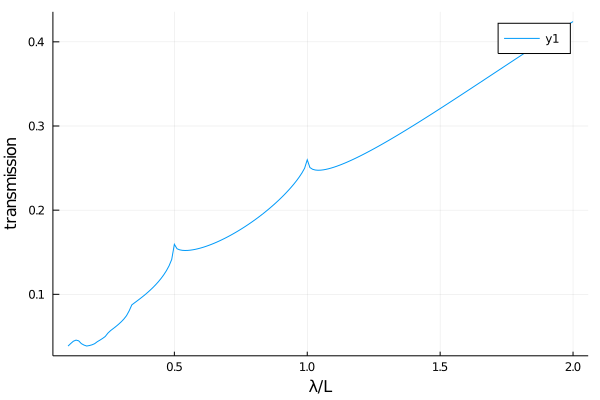

In [392]:
#### 5/19/21
nvec = 0:99
# ϵ = repeat([1e-9], length(nvec)) ## susceptibility
μ = repeat([1e-9], length(nvec))
ϵ = [(n > 40 && n < 60) ? 1e-9 : 1 for n in nvec]
# μ = [(n > 48 && n < 52) ? 1e-9 : 1 for n in nvec]

u_p = [n == 0 ? 1 : 0 for n in nvec]
u_n = [n == 0 ? 0 : 0 for n in nvec]

# S, β = get_all_modes(M, N, 1, 0.5)
L = 1
λᵥ = 0.1:0.01:2
T = zeros(0)
for λ in λᵥ
    ω₀ = 2*pi/λ
    k = ω₀
    kₓ = 2*pi*fftfreq(length(nvec), length(nvec)/L)
    β = @. sqrt(Complex(ω₀^2 - kₓ^2))
    # display(β)

    M = 1im*(k*Matrix(Diagonal(ϵ)))/2
    N = 1im*2/k*Matrix(Diagonal(1 ./μ))

    A = [-Diagonal(β)-k*ifft(fft(M, 2), 1)    -Diagonal(β)-k*ifft(fft(M, 2), 1);
        -Diagonal(β)-k*ifft(fft(N, 2), 1)     Diagonal(β)+k*ifft(fft(N, 2), 1)]
    B = [-Diagonal(β)+k*ifft(fft(M, 2), 1)    -Diagonal(β)+k*ifft(fft(M, 2), 1);
        -Diagonal(β)+k*ifft(fft(N, 2), 1)     Diagonal(β)-k*ifft(fft(N, 2), 1)]
    S = A\B
    # display(S)

    u_in = [u_p; u_n]
    u_out = S*u_in
    # display(u_in)
    # display(u_out)
#     println("reflection: ", abs(u_out[1])^2)
#     println("transmission: ", abs(u_out[5])^2)
#     println("energy: ", abs(u_out[1])^2 + abs(u_out[5])^2, "\n")
    append!(T, abs(u_out[101])^2)
end
plot(λᵥ, T, xlabel="λ/L", ylabel="transmission")

# Checking with Carlos's Solver

100-element Array{Complex{Float64},1}:
  1.1284796772125327e-17 + 1.3066303431223053e-17im
  2.0575798877724085e-17 + 1.4137687879330802e-17im
  2.4609283713488948e-17 + 4.100063245752528e-17im
  3.2041049162184206e-17 - 4.970408390022988e-17im
    8.86711017397971e-18 - 4.20135547641227e-17im
 -2.0384026582255968e-17 - 2.3395133464651976e-17im
   -2.07330099031191e-17 - 1.4730385799987917e-17im
  -4.049058904554924e-18 - 1.608639469714899e-17im
 -2.6935898705670048e-18 - 1.2326847811316307e-17im
  -8.441353237148513e-18 - 1.0116322513177705e-17im
   -9.01084918440029e-18 - 8.303009498358968e-18im
 -1.0686034354051963e-17 - 1.0125152709142016e-17im
   -7.14938406018476e-18 - 5.939902849998335e-18im
                         ⋮
    0.001490909736617077 + 6.533945518311584e-5im
  1.8958057510646928e-17 + 1.6901794631531484e-18im
  2.0900909717139422e-17 + 1.4703150699308367e-18im
  2.4748762958646364e-17 + 1.2467934931848808e-17im
    -0.03582036907076813 + 0.013311419499130991im
   1.5338

100-element Array{Complex{Float64},1}:
  2.0805648691105383e-17 - 9.41404670096459e-18im
  -2.004207050313553e-17 + 1.9411414127324e-17im
   5.481810325767927e-18 + 1.4769847599490864e-17im
   6.181798992894953e-18 - 7.26505553917778e-18im
 -4.1718152368398606e-18 - 3.169779265938383e-17im
  -8.634299618266967e-18 + 3.643735096702906e-18im
 -1.0027441737932904e-17 - 8.117596095530032e-18im
   7.014704948610899e-18 - 1.3702001068270022e-18im
   5.641878118909932e-18 + 9.347588047554676e-18im
  -4.507845571083754e-18 - 1.175349765707372e-19im
   8.939727554359198e-19 - 6.0165539483089e-18im
  -6.282191888220198e-19 + 3.622754571526045e-18im
  -8.633403309180204e-19 - 1.461691651781577e-19im
                         ⋮
 -2.6268729577249017e-18 + 8.434484207648786e-18im
 -5.9063091093283154e-18 + 7.46718248501018e-18im
  -0.0011346573473031444 - 0.008194274023625936im
  -1.644807433447555e-17 - 5.431560701118536e-18im
 -1.1527489106555079e-17 - 8.0024616093871e-18im
  -6.205318337188344e-18

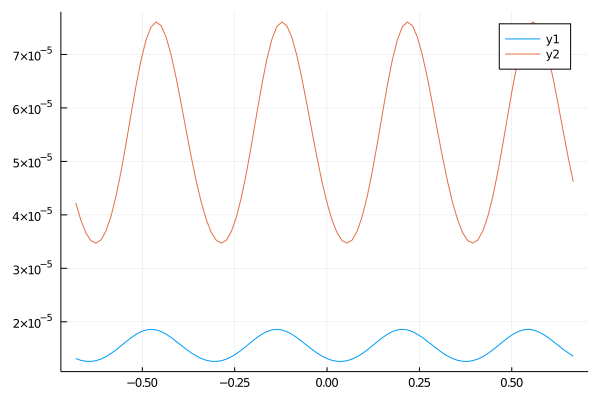

In [2]:
#### Matching Carlos's solver
k = 10.0;
λ = 2*pi/k;
θ = -π/2.0; # incidence angle (measured with respect to the x axis)
α = k*cos(θ);
β = k*sin(θ);
uInc(x,y)= @. exp(1im*α*x+1im*β*y);  # incident planewave

θᵗ = -π/8;    # transmitted field angle
d  = cos(θᵗ)-cos(θ); 
L = 2*(2*π)/(k*abs(d));  # Unit cell width
M₀(x) = @. -sin(θ)*(1+exp(1im*k*d*x));
N₀(x) = @. -sin(θ)*(1-exp(1im*k*d*x));

nvec = 0:99;
dx = L/length(nvec)
xvec = [n*dx-L/2 for n in nvec]
kₓ = 2*pi*fftfreq(length(nvec), 1/dx)
β = @. sqrt(Complex(k^2 - kₓ^2))

u_p = fft(uInc(xvec, 0))/length(nvec)
u_n = zeros(length(nvec))
M = Matrix(Diagonal(M₀(xvec)))
N = Matrix(Diagonal(N₀(xvec)))
# display(N)


A = [-Diagonal(β)-k*ifft(fft(M, 2), 1)    -Diagonal(β)-k*ifft(fft(M, 2), 1);
    -Diagonal(β)-k*ifft(fft(N, 2), 1)     Diagonal(β)+k*ifft(fft(N, 2), 1)]
B = [-Diagonal(β)+k*ifft(fft(M, 2), 1)    -Diagonal(β)+k*ifft(fft(M, 2), 1);
    -Diagonal(β)+k*ifft(fft(N, 2), 1)     Diagonal(β)-k*ifft(fft(N, 2), 1)]
S = A\B
# display(S)

u_in = [u_p; u_n]
u_out = S*u_in
u_out_p = u_out[1:length(nvec)]
u_out_n = u_out[length(nvec)+1:2*length(nvec)]
display(u_out_p)
display(u_out_n)
plot(xvec, abs2.(ifft(u_out_p)))
plot!(xvec, abs2.(ifft(u_out_n)))

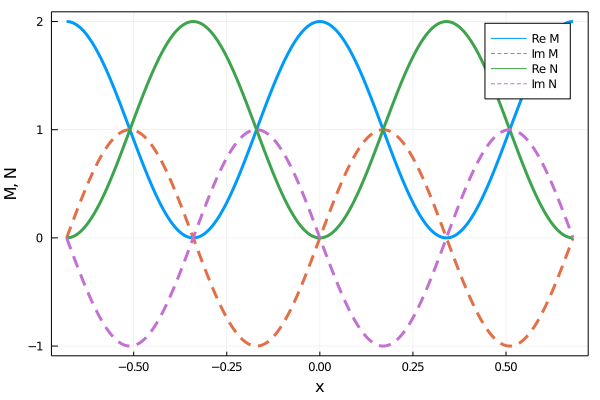

In [3]:
xPlot = -L/2:0.001:L/2;

paramPlot = plot(xPlot,real.(M₀.(xPlot)))

paramPlot = plot!(xPlot,imag.(M₀.(xPlot))) 

paramPlot = plot!(xPlot,real.(N₀.(xPlot))) 

paramPlot = plot!(xPlot,imag.(N₀.(xPlot))) 

plot(paramPlot,lw=3,linestyle=[:solid :dash :solid :dash],label = ["Re M" "Im M" "Re N" "Im N"],frame=:box)
xlabel!("x");ylabel!("M, N")

In [8]:
E1(x,z) = sum([u_out_p[n+1]*exp(-1im*kₓ[n+1]*x)*exp(1im*β[n+1]*z) for n in nvec])+sum([u_p[n+1]*exp(-1im*kₓ[n+1]*x)*exp(1im*β[n+1]*z) for n in nvec])
E2(x,z) = sum([u_out_n[n+1]*exp(-1im*kₓ[n+1]*x)*exp(-1im*β[n+1]*z) for n in nvec])

xview = -L:0.02:L 
zview = 0:0.01:L
zview2 = -L:0.01:0
Emat = zeros(Complex{Float64}, 0)
Emat2 = zeros(Complex{Float64}, 0)
for (z1, z2) in zip(zview, zview2)
    append!(Emat, E1.(xview, z1))
    append!(Emat2, E2.(xview, z2))
end
Emat = reshape(Emat,length(xview),:)
Emat2 = reshape(Emat2,length(xview),:)
# display(Emat)
# display(Emat2)


137×137 Array{Complex{Float64},2}:
  -0.342139+0.637185im    -0.317511+0.649808im    …   -0.641596+0.10522im
  -0.453383+0.563478im    -0.431493+0.580412im        -0.694645+0.00105582im
  -0.549191+0.470588im    -0.530784+0.491255im         -0.73096-0.135976im
  -0.626301+0.361677im    -0.612005+0.385374im        -0.731259-0.302069im
   -0.68209+0.240452im    -0.672391+0.266372im        -0.677898-0.482247im
  -0.714656+0.111041im    -0.709885+0.138302im    …   -0.561882-0.651285im
  -0.722892-0.02215im      -0.72321+0.00552332im      -0.389147-0.779714im
  -0.706517-0.154587im    -0.711914-0.127443im        -0.181956-0.843901im
  -0.666089-0.281762im    -0.676381-0.256071im        0.0271448-0.8357im
  -0.602983-0.399343im     -0.61782-0.375981im         0.206897-0.76597im
  -0.519349-0.503329im    -0.538226-0.483091im    …    0.338457-0.659484im
  -0.418034-0.590179im    -0.440307-0.573754im         0.420125-0.544193im
  -0.302486-0.656937im    -0.327398-0.644883im         0.464159-0.4

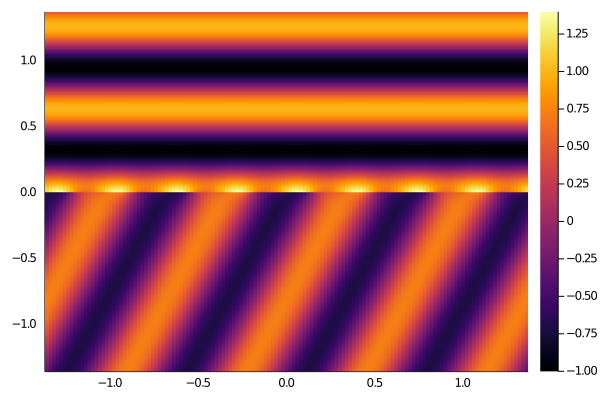

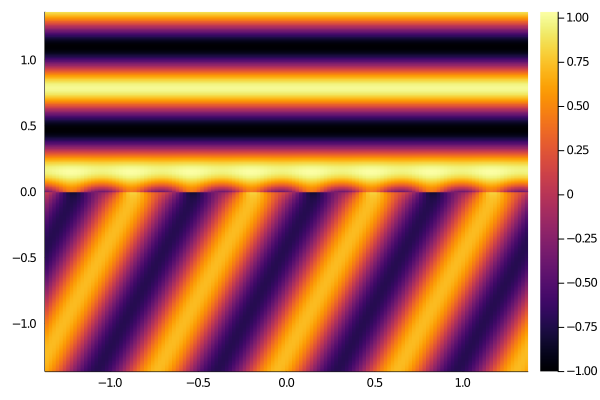

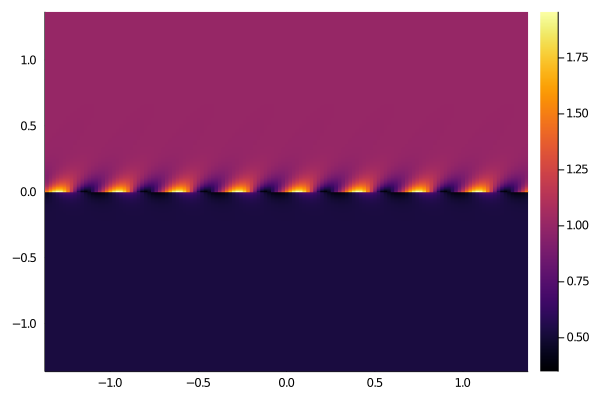

In [9]:
plt1 = heatmap(xview, zview2, transpose(real.(Emat2)))
plt1 = heatmap!(xview, zview, transpose(real.(Emat)))
display(plt1)
plt2 = heatmap(xview, zview2, transpose(imag.(Emat2)))
plt2 = heatmap!(xview, zview, transpose(imag.(Emat)))
display(plt2)
plt3 = heatmap(xview, zview2, transpose(abs2.(Emat2)))
plt3 = heatmap!(xview, zview, transpose(abs2.(Emat)))
display(plt3)